# Using the Wiener-Khinchin theorem to estimate the PSD of a signal with (lots of) missing data

TL;DR: When signals are missing a lot of data power spectral densities (PSD) can't be estimated in the usual way. We can estimate an autocorrelation function, however, just by ignoring the missing data. We can then use the Wiener-Khinchin theorem to the autocorrelation into a PSD.

Suppose we have a spotty time-series signal whose PSD we want to calculate. For instance we might be tracking some feature of an animal's body position as it moves through a natural environment and is frequently occluded. Or we might be reading out brain activity of a freely moving animal, recorded via a battery-powered electrode and transmitted to our computer through an unreliable wireless connection. Or we might have a signal corrupted by a ton of artifacts, whose corresponding timepoints are meaningless to our scientific question.

Passing either of these signals through a conventional Fourier transform may fail when there's so much missing data since most methods for calculating power spectra lack a recipe for handling NaNs. One could try interpolating the missing data first, but that is nontrivial, especially if large chunks are missing.

An alternative approach is to first calculate the autocorrelation function, simply ignoring the NaNs, and then use the Wiener-Khinchin theorem to recover the PSD.

## The Wiener-Khinchin theorem, autocorrelation, and autocovariance

The Wiener-Kinchin theorem is a lovely signal processing theorem stating that the power spectral density $S(f)$ of a wide-sense stationary random process is equal to the Fourier transform of its autocorrelation function $R(\tau)$:

$$S(f) = \int_{-\infty}^\infty R(\tau)e^{-2\pi i f \tau}d\tau$$

and similarly the autocorrelation is the inverse Fourier transform of the power spectral density:

$$R(\tau) = \int_{-\infty}^\infty S(f)e^{2\pi i f \tau} df.$$

I'm not quite sure why, but I feel like this is just so dang cool.

Note that the autocorrelation function $R(\tau)$ is *not* the Pearson correlation between samples offset at different time lags. It is instead defined as:

$$R(\tau) = \textrm{E}\left[ x(t) x(t-\tau) \right]$$

and is related to the covariance $C(\tau)$ of samples offset at different time lags via:

$$C(\tau) = \textrm{E}\left[ x(t) x(t-\tau) \right] - \textrm{E}[x]^2 = R(\tau) - \textrm{E}[x]^2$$

where $\textrm{E}[x]$ is the (time-invariant) expected value of $x(t)$. One key point is that whereas the Pearson correlation is divisively normalized to range from -1 to 1, the autocorrelation function is not normalized. I know it's confusing, but it's just how it is.

Here we'll assume that the mean has been subtracted off from our signal of interest (i.e. $\textrm{E}[x(t)] = 0$) so that

$$R(\tau) = C(\tau) = \textrm{E}\left[ x(t) x(t-\tau) \right]$$

In [1]:
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot

In [2]:
# function for estimating cross or autocorrelation function directly
def get_cov(xs, ys, lag_bkwd, lag_fwd):
    """
    Calculate cross-covariance between x and y for multiple time-series.
    Positive lags correspond to covariances between x at an earlier time
    and y at a later time.
    (Note: this is probably not written in the most efficient way, but it works!)
    
    :param xs: list of input time-series
    :param ys: list of output time-series
    :param lag_bkwd: number of lags to look back (acausal (y yields x))
    :param lag_fwd: number of lags to look forward (causal (x yields y))
    """

    xs = deepcopy(xs)
    ys = deepcopy(ys)

    if not np.all([len(x) == len(y) for x, y in zip(xs, ys)]):

        raise ValueError('Arrays within xs and ys must all be of the same size!')

    covs = []

    for lag in range(lag_bkwd, lag_fwd):

        if lag == 0:

            x_rel = xs
            y_rel = ys

        elif lag < 0:

            x_rel = [x[-lag:] for x in xs if len(x) > -lag]
            y_rel = [y[:lag] for y in ys if len(y) > -lag]

        elif lag > 0:

            x_rel = [x[:-lag] for x in xs if len(x) > lag]
            y_rel = [y[lag:] for y in ys if len(y) > lag]

        all_xs = np.concatenate(x_rel)
        all_ys = np.concatenate(y_rel)
        
        mvalid = (~np.isnan(all_xs)) & (~np.isnan(all_ys))

        cov = np.cov(all_xs[mvalid], all_ys[mvalid])[0, 1]

        covs.append(cov)

    covs = np.array(covs)

    return covs

## Demoing the Wiener-Khinchin theorem with a simulated signal

To see Wiener-Khinchin in action, let's make some fake data, calculate its PSD and autocovariance, and then show they're related by a Fourier transform.

Our signal will be several instances of a white-noise process lightly smoothed with an out-of-the-box Gaussian filter from scipy. We'll take 30 trials of such a signal, each sampled for 2 seconds at 1Khz. Here are three examples below, and in general these could all be different lengths.

We can calculate the PSD by taking the Fourier transform of each signal instance, multiplying it by its complex conjugate, and averaging over all instances. (For more details my demo of using Python to calculate a PSD, especially re: keeping track of units, etc., which can be kind of tricky.)

Note that when you actually compute the PSD you'll notice it is reflected about the Nyquist frequency ($f_{Nyq} = f_s/2$), which is the maximum frequency we can estimate the PSD for.

len(frq) = 1000


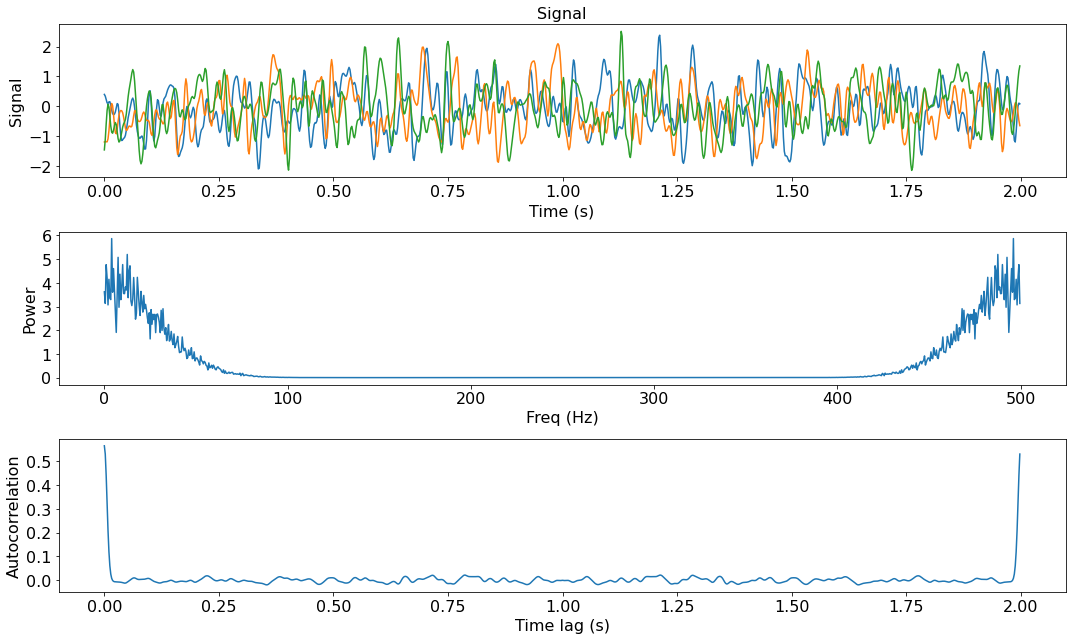

In [7]:
fs = 500
dt = 1/fs  # timestep size
t = np.arange(0, 2, dt)  # time vector
n = len(t)

# noisy signals
from scipy.ndimage import gaussian_filter1d as smooth
xs = np.array([smooth(np.random.normal(0, 2, n), 2) for _ in range(30) ])  # 30 trials

frq = np.fft.fftfreq(n, dt) % (1/dt)  # get frequency vector (arg of Fourier transform)

ffts = np.fft.fft(xs, n, axis=1) / np.sqrt(n)  # since 
psd = np.mean(ffts*np.conj(ffts), axis=0)

print('len(frq) =', len(frq))

fig, axs = plt.subplots(3, 1, figsize=(15, 9), tight_layout=True)
[axs[0].plot(t, x) for x in xs[:3, :]]
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Signal')
axs[0].set_title('Signal')

axs[1].plot(frq, psd)
axs[1].set_xlabel('Freq (Hz)')
axs[1].set_ylabel('Power')

acor_direct_centered = get_cov(xs, xs, -n//2, n//2)
acor_direct = np.roll(acor_direct_centered, n//2)

tcor = np.arange(len(acor_direct))*dt


axs[2].plot(tcor, acor_direct)
axs[2].set_xlabel('Time lag (s)')
axs[2].set_ylabel('Autocorrelation')

for ax in axs:
    set_plot(ax, font_size=16)

## Estimate autocorrelation and show that it is FFT of PSD

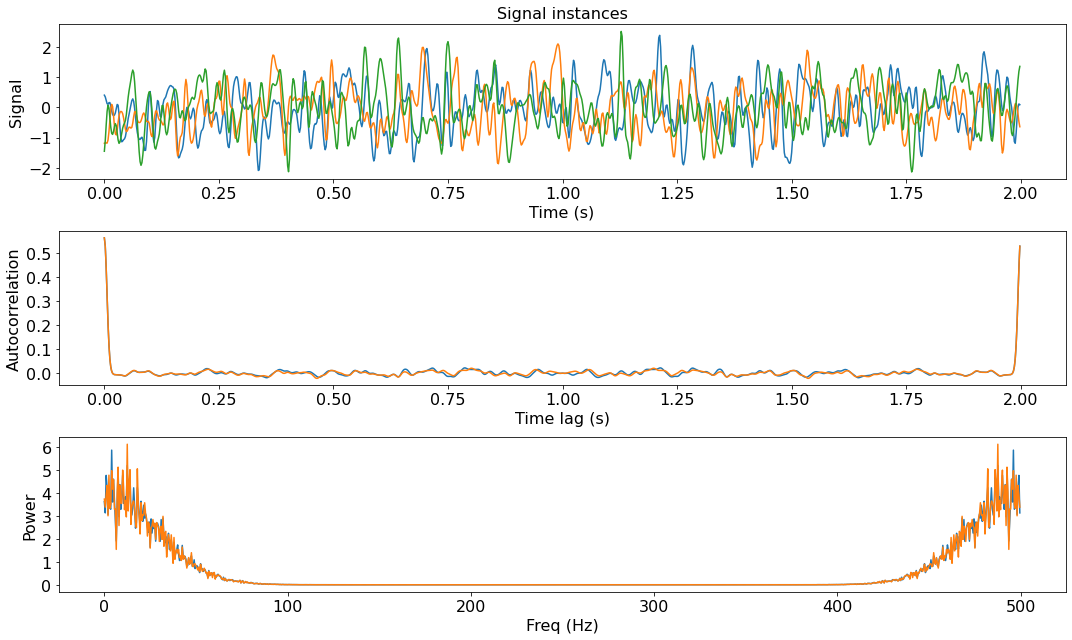

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9), tight_layout=True)

[axs[0].plot(t, x) for x in xs[:3, :]]
set_plot(axs[0], x_label='Time (s)', y_label='Signal', title='Signal instances', font_size=16)

acor_fft = np.real(np.fft.ifft(psd))
axs[1].plot(tcor, acor_direct)
axs[1].plot(tcor, acor_fft)
set_plot(axs[1], x_label='Time lag (s)', y_label='Autocorrelation', font_size=16)

axs[2].plot(frq, psd)
axs[2].plot(frq, np.fft.fft(acor_direct))
set_plot(axs[2], x_label='Freq (Hz)', y_label='Power', font_size=16)

## Convert large fraction of data points to NaNs

In [9]:
xs_corrupted = xs.copy()
xs_corrupted[np.random.rand(*xs_corrupted.shape) < .6] = np.nan  # set 60% of data to nan

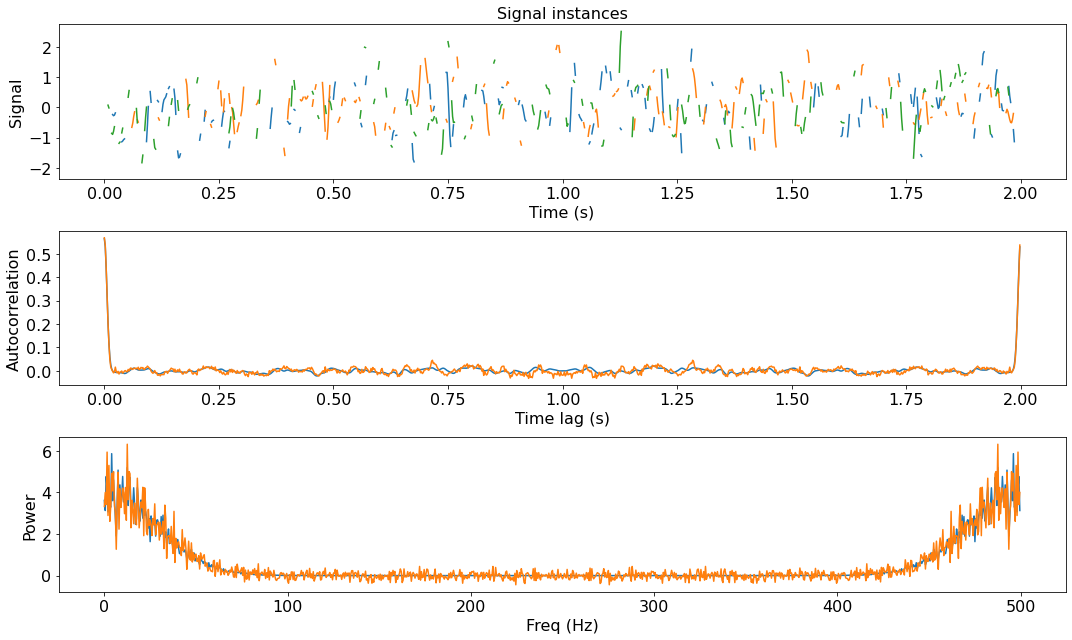

In [10]:
acor_direct_centered = get_cov(xs_corrupted, xs_corrupted, -n//2, n//2)
acor_direct = np.roll(acor_direct_centered, n//2)

fig, axs = plt.subplots(3, 1, figsize=(15, 9), tight_layout=True)

[axs[0].plot(t, x) for x in xs_corrupted[:3, :]]
set_plot(axs[0], x_label='Time (s)', y_label='Signal', title='Signal instances', font_size=16)

axs[1].plot(tcor, acor_fft)
axs[1].plot(tcor, acor_direct)
set_plot(axs[1], x_label='Time lag (s)', y_label='Autocorrelation', font_size=16)

axs[2].plot(frq, psd)
axs[2].plot(frq, np.fft.fft(acor_direct))
set_plot(axs[2], x_label='Freq (Hz)', y_label='Power', font_size=16)

Alt method: Lomb-Scargle periodogram (scipy.signal.lombscargle)